In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pathlib
import os
current_path = os.getcwd()
current_path

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import statistics
import time

from geoband.API import *
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster
import geoplot as gplt
import geoplot.crs as gcrs
import imageio
import mapclassify as mc

import random
from functools import reduce
from collections import defaultdict

from IPython.display import display
from tqdm.notebook import tqdm
import sklearn.cluster
import tensorflow as tf
import pydeck as pdk
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

import shapely
from shapely import wkt
from shapely.geometry import Polygon, Point, shape

# 최적화 solver
from mip import Model, xsum, maximize, BINARY  

# font 
import matplotlib.font_manager as font_manager
path = current_path+'/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path)

font_dirs = [current_path, ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['font.family'] = 'NanumBarunGothic'

Using Python-MIP package version 1.5.3


In [2]:
# Data Load 
df_01 = pd.read_csv(current_path+'/input/1.수원시_버스정류장.csv')
df_02 = pd.read_csv(current_path+'/input/2.수원시_버스정류장별_승하차이력(1).csv')
df_03 = pd.read_csv(current_path+'/input/3.수원시_버스정류장별_승하차이력(2).csv')
df_04 = pd.read_csv(current_path+'/input/4.수원시_버스정류장별_승하차이력(3).csv')
df_05 = pd.read_csv(current_path+'/input/5.수원시_버스정류장별_승하차이력(4).csv')
df_06 = pd.read_csv(current_path+'/input/6.수원시_버스정류장별_승하차이력(5).csv')
df_07 = pd.read_csv(current_path+'/input/7.수원시_버스정류장별_노선현황.csv')
df_08 = pd.read_csv(current_path+'/input/8.수원시_지하철역_위치정보.csv')
df_09 = pd.read_csv(current_path+'/input/9.수원시_지하철역별_이용현황(2017~2019).csv')
df_10 = pd.read_csv(current_path+'/input/10.수원시_옥외광고물현황.csv')
df_11 = pd.read_csv(current_path+'/input/11.수원시_대기오염도_측정현황.csv')
df_12 = pd.read_csv(current_path+'/input/12.수원시_주차장현황.csv')
df_13 = pd.read_csv(current_path+'/input/13.수원시_기상데이터(2020).csv')
df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')
df_17 = gpd.read_file(current_path+'/input/17.수원시_인구정보(고령)_격자.geojson')
df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson')
df_19 = gpd.read_file(current_path+'/input/19.수원시_인구정보(유소년)_격자.geojson')
df_20 = gpd.read_file(current_path+'/input/20.수원시_교통노드.geojson')
df_21 = gpd.read_file(current_path+'/input/21.수원시_교통링크.geojson')
df_22 = gpd.read_file(current_path+'/input/22.수원시_상세도로망_LV6.geojson')
df_23 = pd.read_csv(current_path+'/input/23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
df_24 = pd.read_csv(current_path+'/input/24.수원시_평일_일별_혼잡빈도강도_LV6.csv')
df_25 = pd.read_csv(current_path+'/input/25.수원시_평일_일별_혼잡시간강도_LV6.csv')
df_26 = gpd.read_file(current_path+'/input/26.수원시_인도(2017).geojson')
df_27 = gpd.read_file(current_path+'/input/27.수원시_도로명주소(건물).geojson')
df_28 = gpd.read_file(current_path+'/input/28.수원시_건물연면적_격자.geojson')
df_29 = gpd.read_file(current_path+'/input/29.수원시_법정경계(시군구).geojson')
df_30 = gpd.read_file(current_path+'/input/30.수원시_법정경계(읍면동).geojson')
df_31 = gpd.read_file(current_path+'/input/31.수원시_행정경계(읍면동).geojson')
df_32 = gpd.read_file(current_path+'/input/32.수원시_지적도.geojson')

In [3]:
# pydeck function 
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 
 
def multipolygon_to_center_coordinates(x): 
    lon, lat = x[0].centroid.xy 
    return [[x, y] for x, y in zip(lon, lat)]

def polygon_to_center_coordinates(x): 
    lon, lat = x.centroid.xy
    return [[x, y] for x, y in zip(lon, lat)] 

In [4]:
token = "pk.eyJ1IjoiZGx3b3FsczQzMjMiLCJhIjoiY2tscnR3bG95MDJwaDJ2bjUzcTBrc3h4cyJ9.WigDFX0Gm612haaz4zQ2hg"

# 0. Bus Data  
* df_01 ~ df_07 

## 0-1. Merge Data 

In [14]:
tmp = df_01.merge(df_07[['정류소ID','운행노선','중앙차로여부']], how = 'outer',left_on = '정류장ID',right_on = '정류소ID', copy = False)
del tmp['정류소ID']

df_02_06 = pd.concat([df_02, df_03, df_04, df_05, df_06], axis=0, ignore_index = True)
totalcase = df_02_06.groupby(by=['일자', '정류소ID']).sum([['전체승차건수','초승건수','환승건수','전체하차건수','하차건수','미태그건수']]).reset_index()

bus = totalcase.merge(tmp, how='left', left_on = '정류소ID', right_on = '정류장ID', copy = True ).drop(['정류장ID'], axis=1)

In [15]:
df_02_06.shape, totalcase.shape, bus.shape 

((2508607, 12), (393414, 8), (393414, 23))

In [16]:
# 일자 data type 바꿔주기 
bus['일자'] = bus['일자'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [17]:
# BIS 설치된 정류장만 분석에 이용 
bus = bus[bus["BIS설치여부"] == 1]
bus.shape

(329756, 23)

In [18]:
bus.head(2)

,일자,정류소ID,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부
3,2020-01-01,200000005,46,37,9,261,261,0,광교산입구.경기대수원캠퍼스,시내,일반,경기도 수원시 연무동,1.000000,1.000000,nan,nan,1.000000,nan,nan,127.031546,37.301462,13(수원여객),노변정류장
4,2020-01-01,200000006,389,355,34,257,257,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,nan,1.000000,nan,nan,1.000000,nan,nan,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장


In [19]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329756 entries, 3 to 393410
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   일자          329756 non-null  datetime64[ns]
 1   정류소ID       329756 non-null  int64         
 2   전체 승차 건수    329756 non-null  int64         
 3   초승 건수       329756 non-null  int64         
 4   환승 건수       329756 non-null  int64         
 5   전체 하차 건수    329756 non-null  int64         
 6   하차 건수       329756 non-null  int64         
 7   미태그 건수      329756 non-null  int64         
 8   정류장명        329756 non-null  object        
 9   정류장유형       329756 non-null  object        
 10  환승역타입       326476 non-null  object        
 11  위치(동)       329756 non-null  object        
 12  쉘터          276460 non-null  float64       
 13  BIS설치여부     329756 non-null  float64       
 14  LED         135795 non-null  float64       
 15  LCD         58794 non-null   float64       
 16  LE

In [21]:
# 통계량 확인 
bus.describe()

,정류소ID,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수,쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat
count,329756.000000,329756.000000,329756.000000,329756.000000,329756.000000,329756.000000,329756.000000,276460.000000,329756.000000,135795.000000,58794.000000,126917.000000,8250.000000,0.000000,329756.000000,329756.000000
mean,201546970.340152,297.615510,220.567668,77.047841,290.017904,290.017904,0.000000,1.000000,1.000000,1.013439,1.000000,1.077626,1.000000,nan,127.014769,37.274098
std,1113576.528094,588.432211,335.407710,298.050076,605.501308,605.501308,0.000000,0.000000,0.000000,0.115147,0.000000,0.725223,0.000000,nan,0.035091,0.019361
min,200000005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,126.938013,37.233019
25%,201000050.000000,38.000000,33.000000,2.000000,44.000000,44.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,126.987767,37.259129
50%,201000422.000000,126.000000,109.000000,9.000000,132.000000,132.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,127.016692,37.272205
75%,203000050.000000,342.000000,278.000000,41.000000,319.000000,319.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,127.044120,37.291083
max,203000450.000000,11242.000000,5553.000000,5689.000000,15687.000000,15687.000000,0.000000,1.000000,1.000000,2.000000,1.000000,10.000000,1.000000,nan,127.082425,37.318771


## 0-2. missing data   

In [22]:
# 결측값 확인 
bus.isnull().sum()

일자                 0
정류소ID              0
전체 승차 건수           0
초승 건수              0
환승 건수              0
전체 하차 건수           0
하차 건수              0
미태그 건수             0
정류장명               0
정류장유형              0
환승역타입           3280
위치(동)              0
쉘터             53296
BIS설치여부            0
LED           193961
LCD           270962
LED+LCD복합형    202839
알뜰형           321506
임대형(음성)       329756
lon                0
lat                0
운행노선               0
중앙차로여부             0
dtype: int64

### 1. 환승역타입 

In [23]:
bus.환승역타입.value_counts()

일반    326476
Name: 환승역타입, dtype: int64

In [24]:
# 질문 게시판의 답변으로 미루어 보았을 때, 시내버스 이므로 '일반'으로 채우면 될 것 같음! 
df_01[df_01.환승역타입.isna()]

,정류장ID,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat
153,201000256,서호초등학교,"시내,마을",NaN,경기도 수원시 서둔동,1.000000,1.000000,1.000000,nan,nan,nan,nan,126.990709,37.268556
220,202000010,수원시청역8번출구.씨네파크.헌혈의집,시내,NaN,경기도 수원시 인계동,1.000000,1.000000,nan,nan,1.000000,nan,nan,127.032447,37.263787
340,203000150,그대가프리미어아파트.망포역3번출구,시내,NaN,경기도 수원시 태장동,1.000000,1.000000,1.000000,nan,nan,nan,nan,127.056186,37.244730
570,203000140,망포역7번출구.벽적골8단지,시내,NaN,경기도 수원시 영통2동,1.000000,1.000000,1.000000,nan,nan,nan,nan,127.058455,37.246083
576,203000124,망포역1번출구.디지털엠파이어1,시내,NaN,경기도 수원시 영통2동,1.000000,1.000000,nan,nan,1.000000,nan,nan,127.059642,37.245767
615,202000009,수원시청역10번출구.국민연금공단.경인일보,시내,NaN,경기도 수원시 인계동,1.000000,1.000000,nan,nan,1.000000,nan,nan,127.034362,37.261236
662,202000020,수원시청역9번출구.국민연금공단,시내,NaN,경기도 수원시 인계동,1.000000,1.000000,nan,nan,1.000000,nan,nan,127.032514,37.262877
772,203000346,망포역3번출구.망포그대가프리미어.골든스퀘어,시내,NaN,경기도 수원시 영통2동,1.000000,1.000000,nan,nan,1.000000,nan,nan,127.055024,37.245535
783,203000286,상현역,"시내,마을",NaN,경기도 수원시 광교1동,nan,nan,nan,nan,nan,nan,nan,127.069349,37.296932
897,203000345,망포역4번출구.영통2동주민센터,시내,NaN,경기도 수원시 영통2동,1.000000,1.000000,nan,nan,1.000000,nan,nan,127.055490,37.245954


In [30]:
# 오분류 case 
df_01[df_01.환승역타입 == '환승']

,정류장ID,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat
746,201000538,당수동,"시내,마을",환승,경기도 수원시 입북동,nan,nan,nan,nan,nan,nan,nan,126.944695,37.293880


In [31]:
# '일반'으로 바꿔줌! -> drop 하는게 나을 것 같음 
bus.환승역타입 = '일반'

### 2. 쉘터

In [26]:
# 쉘터 설치되어 있으면 1, 아니면 NaN 
df_01.쉘터.value_counts()

1.000000    781
Name: 쉘터, dtype: int64

In [27]:
bus.쉘터 = bus.쉘터.fillna(0)

### 3. LED / LCD / LED+LCD복합형

In [36]:
# LED 
df_01.LED.value_counts()

1.000000    373
2.000000      5
Name: LED, dtype: int64

In [37]:
# LCD 
df_01.LCD.value_counts()

1.000000    166
Name: LCD, dtype: int64

In [39]:
# LED+LCD복합형 
df_01['LED+LCD복합형'].value_counts()

1.000000     352
4.000000       2
10.000000      2
3.000000       1
2.000000       1
Name: LED+LCD복합형, dtype: int64

In [ ]:
df_01[df_01['LED+LCD복합형'] == 10]

In [42]:
# 설치가 안 되어있다는 것으로 판단, 셋 다 0으로 채워주기! 
bus.LED = bus.LED.fillna(0)
bus.LCD = bus.LCD.fillna(0)
bus['LED+LCD복합형'] = bus['LED+LCD복합형'].fillna(0)

### 4. 알뜰형 / 임대형(음성)

In [45]:
df_01.알뜰형.value_counts()

1.000000    26
Name: 알뜰형, dtype: int64

In [49]:
# 아무것도 없음 .. 
df_01[['임대형(음성)']].value_counts()

Series([], dtype: int64)

In [51]:
# 설치가 안 되어있다는 것으로 판단, 0으로 채워주기! 
bus.알뜰형 = bus.알뜰형.fillna(0)
bus['임대형(음성)'] = bus['임대형(음성)'].fillna(0)

### 5. 최종 dataframe 
* drop 해도 괜찮을 것 같은 변수들 : '환승역타입', '임대형(음성)', 'BIS설치여부'

In [52]:
# 결측값 최종 확인 
bus.isnull().sum()

일자            0
정류소ID         0
전체 승차 건수      0
초승 건수         0
환승 건수         0
전체 하차 건수      0
하차 건수         0
미태그 건수        0
정류장명          0
정류장유형         0
환승역타입         0
위치(동)         0
쉘터            0
BIS설치여부       0
LED           0
LCD           0
LED+LCD복합형    0
알뜰형           0
임대형(음성)       0
lon           0
lat           0
운행노선          0
중앙차로여부        0
dtype: int64

In [57]:
bus.to_excel(current_path+'/data/bus.xlsx', index=False)

In [5]:
bus = pd.read_excel(current_path+'/data/bus.xlsx')
bus.shape

(329756, 23)

# 1. 버스 외부데이터 합치기 (과연.. 이게 맞을까..) 
* **경기 버스 정보** : http://www.gbis.go.kr/
* GGD_RouteInfo_M.xls : 버스 노선 정보 (기점, 종점 / 주중배차간격, 주말배차간격 / 첫차, 막차 시간) 
* GGD_RouteStationInfo_M.xls : 노선 경유 정보 (버스 노선 순서) 

In [6]:
route = pd.read_excel(current_path+'/data/GGD_RouteInfo_M.xls')
trans = pd.read_excel(current_path+'/data/GGD_RouteStationInfo_M.xls', sheet_name=[0,1,2])

In [7]:
# route : 업체명으로 거르기 
'''
1. df_02 : ['(주)용남고속버스라인', '경기고속', '경남여객', '경원여객', '경진여객운수(주)', '남양여객']
2. df_03 : ['남양여객', '대원고속', '대원버스', '삼경운수(주)', '성우운수(주)', '성남시내버스(주)', '수원여객']
4. df_05 : ['수원여객', '오산교통', '용남고속']
5. df_06 : ['용남고속', '제부여객', '태화상운', '화성도시공사', '화성여객(주)']
'''

comp = ['용남고속', '경기고속', '경남여객', '용인-경남여객', '경원여객', '경진여객', '남양여객',
        '대원고속', '대원버스', '삼경운수', '성우운수', '성남시내버스', '수원여객', '오산교통', '오산-오산교통', 
        '제부여객', '남양주-태화상운', '태화상운', '화성도시공사', '화성여객'] 

In [8]:
route = route[route["운행업체"].isin(comp)]
trans = pd.concat([trans[0], trans[1], trans[2]], axis=0, ignore_index = True)

In [9]:
# route : 버스 노선 정보 
print(route.shape)
route.head()

(1088, 15)


,순번,관할관청,운행업체,노선번호,노선ID,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차
94,95,고양시,대원고속,9700,219000026,킨텍스제2전시장(경유),277103703,교육개발원입구(중),121000001,55분~70분,75분~85분,05:00,22:45,06:10,00:00
281,282,광주시,대원고속,521,204000025,퉁점골,234000050,판교역.낙생육교.현대백화점,206000532,15분~30분,20분~30분,05:50,21:40,06:50,22:40
282,283,광주시,대원고속,521,204000025,퉁점골,234000050,판교역.낙생육교.현대백화점,206000532,15분~30분,20분~30분,06:00,21:40,06:50,22:40
283,284,광주시,대원고속,3200,218000005,성사고등학교,218000501,인천공항3층출국장(T2),161000611,20분~40분,20분~40분,04:00,21:00,05:40,23:10
284,285,광주시,경기고속,M2316,222000105,영남아파트.풍림아이원아파트,222000757,잠실광역환승센터,123000611,12분~25분,20분~30분,05:20,23:05,06:15,00:00


In [11]:
# trans : 버스 노선 순서 
print(trans.shape)
trans.head()

(192708, 7)


,순번,ROUTE_ID,ROUTE_NM,STA_ORDER,STATION_NM,STATION_ID,MOBILE_NO
0,1,200000006,300,1,하북차고지,214001151,15578.000000
1,2,200000006,300,2,서탄입구,214000514,15568.000000
2,3,200000006,300,3,진위역,214000513,15565.000000
3,4,200000006,300,4,하북4리.사리고가,214000512,15566.000000
4,5,200000006,300,5,진위면롯데제과,214000511,15580.000000


In [11]:
# 업체명으로 거르면 완벽하게 걸러지지 않는 문제가 생김 ~ 
route[route["노선번호"] == '64']

,순번,관할관청,운행업체,노선번호,노선ID,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차
982,983,남양주시,남양주-태화상운,64,241349007,봉인사,222001804,금곡동구종점.금곡초교,222000142,40분,NaN,6:30,22:15,NaN,NaN
1309,1310,수원시,수원여객,64,200000043,동탄차고지,233001222,안양역,208000068,20분~23분,24분~28분,04:50,21:50,06:30,23:35


In [87]:
# 버정에 어떤 버스가 어떻게 다니는지 알려주는 데이터 
trans[trans["STATION_ID"] == 200000006]

,순번,ROUTE_ID,ROUTE_NM,STA_ORDER,STATION_NM,STATION_ID,MOBILE_NO
1715,1716,200000032,16,2,광교공원.경기대수원캠퍼스입구.연무시장,200000006,1197.000000
1847,1848,200000037,13,13,광교공원.경기대수원캠퍼스입구.연무시장,200000006,1197.000000
2419,2420,200000045,7-1,55,광교공원.경기대수원캠퍼스입구.연무시장,200000006,1197.000000
2568,2569,200000051,16-1,2,광교공원.경기대수원캠퍼스입구.연무시장,200000006,1197.000000
4546,4547,200000099,37,1,광교공원.경기대수원캠퍼스입구.연무시장,200000006,1197.000000
5634,5635,200000134,32-5,2,광교공원.경기대수원캠퍼스입구.연무시장,200000006,1197.000000
6101,6102,200000148,35,2,광교공원.경기대수원캠퍼스입구.연무시장,200000006,1197.000000
9153,9154,200000288,16-2,2,광교공원.경기대수원캠퍼스입구.연무시장,200000006,1197.000000


In [13]:
# 원래 주어진 데이터에는 이렇게 저장되어 있음! 
bus[bus["정류소ID"] == 200000006]["운행노선"].iloc[0]

'13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수원여객),35(수원여객),37(수원여객),37(용남고속),7-1(수원여객)'

## 1. bus + trans 
* **STATION_ID** 가 공통으로 존재하는 bus, trans df 합치기 
* bus 고유 정보에 대해 merge 하는 것이므로, 일자별로 펼친 데이터 말고, df_01 이용하기로 함! 

In [14]:
tmp = df_01.merge(df_07[['정류소ID','운행노선','중앙차로여부']], how = 'outer',left_on = '정류장ID',right_on = '정류소ID', copy = False)
del tmp['정류소ID']

tmp.shape, df_01.shape, df_07.shape

((1179, 16), (1179, 14), (1128, 7))

In [15]:
tmp = tmp[['정류장ID', '정류장명', '정류장유형', '위치(동)', 'lon', 'lat', '운행노선']]
tmp.head()

,정류장ID,정류장명,정류장유형,위치(동),lon,lat,운행노선
0,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)"
1,201000344,중보들공원,"시내,마을",경기도 수원시 평동,126.991029,37.244605,123A(용남고속)
2,201000345,남수원초등학교,시내,경기도 수원시 세류2동,127.016000,37.251091,82-1(수원여객)
3,201000379,신미주아파트,시내,경기도 수원시 금곡동,126.953845,37.268806,"61(수원여객),9-1(용남고속)"
4,201000055,농수산물시장,시내,경기도 수원시 권선1동,127.029815,37.256755,"13-1(수원여객),3002(용남고속),4000(성우운수(주)),4500(성남시내버..."


In [16]:
print(tmp.shape)
tmp.isnull().sum()

(1179, 7)


정류장ID     0
정류장명      0
정류장유형     0
위치(동)     0
lon       0
lat       0
운행노선     51
dtype: int64

In [17]:
# bus 데이터에 운행노선 결측값 없으므로, 운행노선 없는 row drop 
tmp = tmp.dropna(axis=0)

In [18]:
# 버스 노선 순서 데이터 
trans2 = trans.rename(columns = {"STATION_ID": "정류장ID", "ROUTE_ID": "노선ID", "ROUTE_NM": "노선번호", "STA_ORDER": "노선순서", "STATION_NM": "정류장명"})
trans2 = trans2.drop(["순번", "MOBILE_NO"], axis=1)
trans2.head(3)

,노선ID,노선번호,노선순서,정류장명,정류장ID
0,200000006,300,1,하북차고지,214001151
1,200000006,300,2,서탄입구,214000514
2,200000006,300,3,진위역,214000513


In [23]:
# 주어진 bus (df_01, df_07) 데이터랑 수원시 데이터랑 개수가 안 맞음 ㅜㅜ 

print("Compas data : ", len(tmp[tmp["정류장ID"] == 201000055]["운행노선"].iloc[0].split(','))) 
print(tmp[tmp["정류장ID"] == 201000055]["운행노선"].iloc[0])
print("=====" * 10)
print("Suwon data : ", trans2[trans2["정류장ID"] == 201000055].shape[0])
trans2[trans2["정류장ID"] == 201000055]

Compas data :  6
13-1(수원여객),3002(용남고속),4000(성우운수(주)),4500(성남시내버스(주)),80(수원여객),99-2(용남고속)
Suwon data :  7


,노선ID,노선번호,노선순서,정류장명,정류장ID
3289,200000069,13-1,35,농수산물시장,201000055
6005,200000145,3002,70,농수산물시장,201000055
6086,200000146,80,74,농수산물시장,201000055
7346,200000196,99-2,51,농수산물시장,201000055
7811,200000211,20-2,27,농수산물시장,201000055
9650,200000314,4000,115,농수산물시장,201000055
11666,204000056,4500,42,농수산물시장,201000055


In [30]:
# Data Merge 
tmp2 = tmp.merge(trans2.drop(["정류장명"], axis=1), how='left', on='정류장ID')
print("bus+trans shape : ", tmp2.shape , '\n') 
print("원래 데이터의 unique bus 개수 : ", tmp.정류장ID.nunique())
print("합친 데이터의 unique bus 개수 : ", tmp2.정류장ID.nunique())
print("=====" * 20)
tmp2.head()

bus+trans shape :  (8567, 10) 

원래 데이터의 unique bus 개수 :  1128
합친 데이터의 unique bus 개수 :  1128


,정류장ID,정류장명,정류장유형,위치(동),lon,lat,운행노선,노선ID,노선번호,노선순서
0,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000093.000000,51,5.000000
1,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000107.000000,88,5.000000
2,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000199.000000,88-1,5.000000
3,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",241204001.000000,27,8.000000
4,201000344,중보들공원,"시내,마을",경기도 수원시 평동,126.991029,37.244605,123A(용남고속),200000269.000000,123A,14.000000


In [32]:
# issue : 어디에 맞춰야 할지 모르겠음 .. 
print("원래 데이터의 운행 노선 개수 : ", len(tmp[tmp["정류장ID"] == 202000208]['운행노선'].iloc[0].split(',')))
print("합친 데이터의 운행 노선 개수 : ", tmp2[tmp2["정류장ID"] == 202000208].shape[0]) 

원래 데이터의 운행 노선 개수 :  40
합친 데이터의 운행 노선 개수 :  38


In [61]:
# 합친 데이터 
tmp2[(tmp2["정류장ID"] == 202000208) & (tmp2["노선번호"] == '92')]

,정류장ID,정류장명,정류장유형,위치(동),lon,lat,운행노선,노선ID,노선번호,노선순서
6767,202000208,수원역.노보텔수원,"시내,마을,공항",경기도 수원시 매산동,126.999608,37.268112,"10(경남여객),10-2(경남여객),10-5(경남여객),1004(제부여객),1004...",200000025.000000,92,76.000000


In [37]:
# 원래 데이터 
df_02_06 = pd.concat([df_02, df_03, df_04, df_05, df_06], axis=0, ignore_index = True)

In [38]:
# 92 : 수원여객 & 용남고속 모두 존재 : 더하기 (groupby sum)
df_02_06[(df_02_06["정류소ID"] == 202000208) & (df_02_06["노선번호"] == '92')].drop_duplicates(subset=['업체명', '노선번호', '노선유형', '정류소명', '정류소ID'], keep='first')

,일자,업체명,노선번호,노선유형,정류소명,정류소ID,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수
1680527,20200102,수원여객,92,일반형시내버스,수원역.노보텔수원,202000208,293,80,213,355,355,0
2248837,20200102,용남고속,92,일반형시내버스,수원역.노보텔수원,202000208,136,45,91,117,117,0


In [40]:
# 37 : 수원여객 & 용남고속 모두 존재해야 하는데.. 37번은 용남고속만 존재... ㅎㅎ..  
df_02_06[(df_02_06["정류소ID"] == 202000208) & (df_02_06["노선번호"] == '37')].drop_duplicates(subset=['업체명', '노선번호', '노선유형', '정류소명', '정류소ID'], keep='last')

,일자,업체명,노선번호,노선유형,정류소명,정류소ID,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수
2044065,20201231,용남고속,37,일반형시내버스,수원역.노보텔수원,202000208,70,23,47,142,142,0


In [42]:
tmp2.head()

,정류장ID,정류장명,정류장유형,위치(동),lon,lat,운행노선,노선ID,노선번호,노선순서
0,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000093.000000,51,5.000000
1,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000107.000000,88,5.000000
2,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000199.000000,88-1,5.000000
3,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",241204001.000000,27,8.000000
4,201000344,중보들공원,"시내,마을",경기도 수원시 평동,126.991029,37.244605,123A(용남고속),200000269.000000,123A,14.000000


In [53]:
tmp2.isnull().sum()

정류장ID    0
정류장명     0
정류장유형    0
위치(동)    0
lon      0
lat      0
운행노선     0
노선ID     2
노선번호     2
노선순서     2
dtype: int64

In [54]:
# 결측값 존재! 
tmp2[tmp2.노선ID.isna()]

,정류장ID,정류장명,정류장유형,위치(동),lon,lat,운행노선,노선ID,노선번호,노선순서
8455,203000058,연화장,시내,경기도 수원시 광교1동,127.083096,37.290865,22(남양여객),nan,NaN,nan
8467,203000194,경희대정문,시내,경기도 수원시 영통1동,127.078818,37.247496,5500-1(경기고속),nan,NaN,nan


In [55]:
tmp2.shape

(8567, 10)

## 2. bus + trans + route 
* 위에서 만든 tmp2 기준으로 합치기! 
* **노선번호 & 노선ID** 가 공통으로 존재 

In [94]:
# Data Merge 
tmp3 = pd.merge(left=tmp2, right=route.drop_duplicates('노선ID'), how='left', \
                on=['노선ID','노선번호'])

print("bus+trans+route shape : ", tmp3.shape , '\n') 
print("원래 데이터의 unique bus 개수 : ", tmp.정류장ID.nunique())
print("합친 데이터의 unique bus 개수 : ", tmp3.정류장ID.nunique())
print("=====" * 20)
tmp3.head()

bus+trans+route shape :  (8567, 23) 

원래 데이터의 unique bus 개수 :  1128
합친 데이터의 unique bus 개수 :  1128


,정류장ID,정류장명,정류장유형,위치(동),lon,lat,운행노선,노선ID,노선번호,노선순서,순번,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차
0,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000093.000000,51,5.000000,3096.000000,화성시,제부여객,능실마을21단지.수원여대입구,201000448.000000,동탄2차고지,233003123.000000,50분~60분,90분,05:00,22:30,05:30,22:40
1,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000107.000000,88,5.000000,1332.000000,수원시,용남고속,능실마을21단지.수원여대입구,201000448.000000,조원뉴타운,200000047.000000,12분~14분,20분~28분,04:40,22:30,05:20,23:30
2,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000199.000000,88-1,5.000000,1360.000000,수원시,용남고속,능실마을21단지.수원여대입구,201000448.000000,상현중학교,228002008.000000,20분~25분,20분~40분,04:45,22:10,05:15,23:10
3,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",241204001.000000,27,8.000000,nan,NaN,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN
4,201000344,중보들공원,"시내,마을",경기도 수원시 평동,126.991029,37.244605,123A(용남고속),200000269.000000,123A,14.000000,1371.000000,수원시,용남고속,경기도청입구,202000200.000000,LG빌리지2차.휴먼시아5단지아파트,201000244.000000,50분~60분,80분~100분,06:30,22:00,07:30,23:00


In [95]:
tmp3.isnull().sum()

정류장ID              0
정류장명               0
정류장유형              0
위치(동)              0
lon                0
lat                0
운행노선               0
노선ID               2
노선번호               2
노선순서               2
순번               835
관할관청             835
운행업체             835
기점               835
기점_STATION_ID    835
종점               835
종점_STATION_ID    835
주중배차간격           906
주말배차간격           949
상행첫차             835
상행막차             835
하행첫차             884
하행막차             884
dtype: int64

## 3. date + bus + trans + route 
* 윤희가 합쳐 놓은 **bus** 데이터에 위에서 만든 **tmp3** 데이터 합치기 
* **정류소ID** 기준, **일자**별로 펼쳐진 dataframe 

In [137]:
# Data Merge 
total = pd.merge(left=bus, right=tmp3.drop(['정류장유형', '위치(동)', 'lon', 'lat', '운행노선', '순번'], axis=1).drop_duplicates(),  
                 how='left', left_on = ['정류소ID', '정류장명'], right_on = ['정류장ID', '정류장명'])
del total["정류장ID"]

print("date+bus+trans+route shape : ", total.shape , '\n') 
print("bus 데이터의 unique bus 개수 : ", bus.정류소ID.nunique())
print("tmp3 데이터의 unique bus 개수 : ", tmp3.정류장ID.nunique())
print("합친 데이터의 unique bus 개수 : ", total.정류소ID.nunique())
print("=====" * 20)
total.head(3)

date+bus+trans+route shape :  (2725417, 38) 

bus 데이터의 unique bus 개수 :  919
tmp3 데이터의 unique bus 개수 :  1128
합친 데이터의 unique bus 개수 :  919


,일자,정류소ID,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선번호,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차
0,2020-01-01,200000005,46,37,9,261,261,0,광교산입구.경기대수원캠퍼스,시내,일반,경기도 수원시 연무동,1,1,0,0,1,0,0,127.031546,37.301462,13(수원여객),노변정류장,200000037.000000,13,70.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,06:00,22:00,05:40,23:10
1,2020-01-01,200000006,389,355,34,257,257,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0,1,0,0,1,0,0,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000032.000000,16,2.000000,수원시,수원여객,경기대정문,203000229.000000,하저리마을회관,233001340.000000,210분,210분,07:00,20:25,08:30,21:55
2,2020-01-01,200000006,389,355,34,257,257,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0,1,0,0,1,0,0,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000037.000000,13,13.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,06:00,22:00,05:40,23:10


In [119]:
total.isnull().sum()

일자                    0
정류소ID                 0
전체 승차 건수              0
초승 건수                 0
환승 건수                 0
전체 하차 건수              0
하차 건수                 0
미태그 건수                0
정류장명                  0
정류장유형                 0
환승역타입                 0
위치(동)                 0
쉘터                    0
BIS설치여부               0
LED                   0
LCD                   0
LED+LCD복합형            0
알뜰형                   0
임대형(음성)               0
lon                   0
lat                   0
운행노선                  0
중앙차로여부                0
노선ID                  0
노선번호                  0
노선순서                  0
관할관청             248301
운행업체             248301
기점               248301
기점_STATION_ID    248301
종점               248301
종점_STATION_ID    248301
주중배차간격           270181
주말배차간격           285496
상행첫차             248301
상행막차             248301
하행첫차             265801
하행막차             265801
dtype: int64

In [120]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2725417 entries, 0 to 2725416
Data columns (total 38 columns):
 #   Column         Dtype         
---  ------         -----         
 0   일자             datetime64[ns]
 1   정류소ID          int64         
 2   전체 승차 건수       int64         
 3   초승 건수          int64         
 4   환승 건수          int64         
 5   전체 하차 건수       int64         
 6   하차 건수          int64         
 7   미태그 건수         int64         
 8   정류장명           object        
 9   정류장유형          object        
 10  환승역타입          object        
 11  위치(동)          object        
 12  쉘터             int64         
 13  BIS설치여부        int64         
 14  LED            int64         
 15  LCD            int64         
 16  LED+LCD복합형     int64         
 17  알뜰형            int64         
 18  임대형(음성)        int64         
 19  lon            float64       
 20  lat            float64       
 21  운행노선           object        
 22  중앙차로여부         object        
 23  노선ID   

## 4. 추가사항 
* 데이터 크기가 말도 안 되게 커서, 이걸 그대로 활용하기에는 무리일 것 같고, 
  여기서 동별로 나누던지 혹은 버스별로 나누던지... 쪼개는 방법을 생각해 봐야 할 것 같음  <br>
  (사실 이걸 그대로 가지고 가는게 좋을지도 잘 모르겠음) 
* 혹은 버스정류장ID 기준으로, 노선 개수를 평균을 해서 활용한다거나.. <br>
  (= 윤희가 처음에 만들어 놓은 df랑 똑같은 크기로 만들어서 활용하자는 말)
* 추가적으로 **주중배차간격, 주말배차간격, 상행첫차, 상행막차, 하행첫차, 하행막차** column 정제 필요!
---
Feature 
* 운행시간 : 막차시간 - 첫차시간 
* 운행횟수 : 운행시간 / 배차간격 

# 여기까지만 돌리세용 

# 2. 유동인구 데이터 합치기  
* 격자가 아니라 **위경도 데이터**인데.. 어떻게 합칠까.. (50X50 중점)  
* df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
* df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
* df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')

## 1. 격자 데이터 활용하기 
* df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson') 
* (100 X 100) 격자 데이터 

In [140]:
tmp3.shape

(8567, 23)

In [143]:
tmp3.head(1)

,정류장ID,정류장명,정류장유형,위치(동),lon,lat,운행노선,노선ID,노선번호,노선순서,순번,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차
0,201000313,권선구청,"시내,마을",경기도 수원시 서둔동,126.970983,37.256983,"51(제부여객),88(용남고속),88-1(용남고속)",200000093.000000,51,5.000000,3096.000000,화성시,제부여객,능실마을21단지.수원여대입구,201000448.000000,동탄2차고지,233003123.000000,50분~60분,90분,05:00,22:30,05:30,22:40


In [ ]:
for t in tmp3 : 
    point = Point(t['lon'], t['lat'])
    

In [121]:
df_18.head()

,gid,val,geometry
0,다사491193,nan,"MULTIPOLYGON (((126.92589 37.27122, 126.92589 ..."
1,다사492193,nan,"MULTIPOLYGON (((126.92702 37.27123, 126.92701 ..."
2,다사492194,nan,"MULTIPOLYGON (((126.92701 37.27213, 126.92701 ..."
3,다사492195,nan,"MULTIPOLYGON (((126.92701 37.27303, 126.92700 ..."
4,다사492196,nan,"MULTIPOLYGON (((126.92700 37.27393, 126.92699 ..."


In [122]:
pop = df_18.fillna(0)
pop['coordinates'] = pop['geometry'].apply(multipolygon_to_coordinates)

In [123]:
pop.head()

,gid,val,geometry,coordinates
0,다사491193,0.000000,"MULTIPOLYGON (((126.92589 37.27122, 126.92589 ...","[[126.92589305000297, 37.27122188401471], [126..."
1,다사492193,0.000000,"MULTIPOLYGON (((126.92702 37.27123, 126.92701 ...","[[126.92702090995468, 37.271227348287326], [12..."
2,다사492194,0.000000,"MULTIPOLYGON (((126.92701 37.27213, 126.92701 ...","[[126.92701407912415, 37.27212870465317], [126..."
3,다사492195,0.000000,"MULTIPOLYGON (((126.92701 37.27303, 126.92700 ...","[[126.92700724798952, 37.27303006088036], [126..."
4,다사492196,0.000000,"MULTIPOLYGON (((126.92700 37.27393, 126.92699 ...","[[126.92700041655083, 37.2739314169689], [126...."


In [ ]:
for feature in js['features']:
    polygon = shape(feature['geometry'])
    if polygon.contains(point):
        print 'Found containing polygon:', feature

In [128]:
point = Point(126.929668, 37.270151)

In [136]:
i = 0
for c in pop['geometry'] : 
    polygon = shape(c)
    if polygon.contains(point):
        print(polygon)

MULTIPOLYGON (((126.9292902377457 37.26943553074496, 126.9292834344091 37.27033688774156, 126.9304112818277 37.27034231960491, 126.9304180717213 37.2694409624321, 126.9292902377457 37.26943553074496)))


In [129]:
df_14.shape

(416080, 27)

In [130]:
df_14.head()

,STD_YM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,TMST_09,TMST_10,TMST_11,TMST_12,TMST_13,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,lon,lat
0,2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,126.929668,37.270151
1,2020-01-01,0.040000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.040000,0.040000,0.040000,0.040000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.070000,0.070000,0.050000,0.050000,0.050000,0.040000,126.930229,37.270604
2,2020-01-01,0.050000,0.050000,0.040000,0.020000,0.020000,0.040000,0.040000,0.040000,0.050000,0.070000,0.070000,0.070000,0.070000,0.090000,0.090000,0.090000,0.110000,0.110000,0.120000,0.120000,0.110000,0.120000,0.110000,0.090000,126.930188,37.276012
3,2020-01-01,0.020000,0.020000,0.020000,0.000000,0.000000,0.000000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.020000,126.931363,37.269708
4,2020-01-01,0.020000,0.020000,0.000000,0.000000,0.000000,0.020000,0.020000,0.020000,0.070000,0.040000,0.050000,0.050000,0.070000,0.050000,0.070000,0.070000,0.070000,0.070000,0.090000,0.090000,0.070000,0.050000,0.050000,0.040000,126.931319,37.275567


In [113]:
# STD_YM data type 바꿔주기 
df_14['STD_YM'] = df_14['STD_YM'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
df_15['STD_YM'] = df_15['STD_YM'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
df_16['STD_YM'] = df_16['STD_YM'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))

In [114]:
df_14.columns

Index(['STD_YM', 'TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06', 'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23', 'lon', 'lat'], dtype='object')

In [115]:
df_15.columns

Index(['STD_YM', 'MAN_FLOW_POP_CNT_10G', 'MAN_FLOW_POP_CNT_20G', 'MAN_FLOW_POP_CNT_30G', 'MAN_FLOW_POP_CNT_40G', 'MAN_FLOW_POP_CNT_50G', 'MAN_FLOW_POP_CNT_60GU', 'WMAN_FLOW_POP_CNT_10G', 'WMAN_FLOW_POP_CNT_20G', 'WMAN_FLOW_POP_CNT_30G', 'WMAN_FLOW_POP_CNT_40G', 'WMAN_FLOW_POP_CNT_50G', 'WMAN_FLOW_POP_CNT_60GU', 'lon', 'lat'], dtype='object')

In [116]:
df_16.columns

Index(['STD_YM', 'FLOW_POP_CNT_MON', 'FLOW_POP_CNT_TUS', 'FLOW_POP_CNT_WED', 'FLOW_POP_CNT_THU', 'FLOW_POP_CNT_FRI', 'FLOW_POP_CNT_SAT', 'FLOW_POP_CNT_SUN', 'lon', 'lat'], dtype='object')

In [117]:
df_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416080 entries, 0 to 416079
Data columns (total 27 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   STD_YM   416080 non-null  datetime64[ns]
 1   TMST_00  416080 non-null  float64       
 2   TMST_01  416080 non-null  float64       
 3   TMST_02  416080 non-null  float64       
 4   TMST_03  416080 non-null  float64       
 5   TMST_04  416080 non-null  float64       
 6   TMST_05  416080 non-null  float64       
 7   TMST_06  416080 non-null  float64       
 8   TMST_07  416080 non-null  float64       
 9   TMST_08  416080 non-null  float64       
 10  TMST_09  416080 non-null  float64       
 11  TMST_10  416080 non-null  float64       
 12  TMST_11  416080 non-null  float64       
 13  TMST_12  416080 non-null  float64       
 14  TMST_13  416080 non-null  float64       
 15  TMST_14  416080 non-null  float64       
 16  TMST_15  416080 non-null  float64       
 17  TMST_16  4

In [6]:
df_08.head()

,역사명,노선명,lon,lat
0,성균관대역,경부선,126.970861,37.300344
1,화서역,경부선,126.989581,37.283990
2,수원(분당)역,분당선,126.999821,37.266162
3,세류역,경부선,127.013772,37.244102
4,청명역,분당선,127.078945,37.259485


In [7]:
df_09.head()

,호선명,역명,행정구역,월,승하차,모든요일(2017),모든요일(2018),모든요일(2019)
0,경부선,성균관대역,율천동(경기수원장안),1월,승차,"419,507","440,655","462,602"
1,경부선,성균관대역,율천동(경기수원장안),1월,하차,"403,536","428,397","456,366"
2,경부선,화서역,화서2동(경기수원팔달),1월,승차,"231,583","234,214","247,670"
3,경부선,화서역,화서2동(경기수원팔달),1월,하차,"229,975","230,293","241,518"
4,경부선,수원,매산동(경기수원팔달),1월,승차,"1,096,575","1,071,454","1,088,978"


In [86]:
jan = df_09[df_09["월"] == "3월"]
jan = jan[jan["승하차"] == "승차"]
jan.shape

(11, 8)

In [87]:
jan

,호선명,역명,행정구역,월,승하차,모든요일(2017),모든요일(2018),모든요일(2019)
44,경부선,성균관대역,율천동(경기수원장안),3월,승차,"546,122","549,777","533,650"
46,경부선,화서역,화서2동(경기수원팔달),3월,승차,"280,781","271,602","269,218"
48,경부선,수원,매산동(경기수원팔달),3월,승차,"1,330,390","1,335,178","1,301,066"
50,경부선,세류역,세류2동(경기수원권선),3월,승차,"139,576","129,654","125,007"
52,분당선,수원(분당)역,매산동(경기수원팔달),3월,승차,"492,048","533,257","543,583"
54,분당선,청명역,영통1동(경기수원영통),3월,승차,"137,702","138,416","138,950"
56,분당선,영통역,영통2동(경기수원영통),3월,승차,"304,941","317,117","322,386"
58,분당선,망포역,영통2동(경기수원영통),3월,승차,"406,889","432,324","437,839"
60,분당선,매탄권선역,권선1동(경기수원권선),3월,승차,"145,434","149,780","148,611"
62,분당선,수원시청역,인계동(경기수원팔달),3월,승차,"339,023","372,867","381,258"


In [88]:
jan = jan.drop([48], axis=0)

In [89]:
jan

,호선명,역명,행정구역,월,승하차,모든요일(2017),모든요일(2018),모든요일(2019)
44,경부선,성균관대역,율천동(경기수원장안),3월,승차,"546,122","549,777","533,650"
46,경부선,화서역,화서2동(경기수원팔달),3월,승차,"280,781","271,602","269,218"
50,경부선,세류역,세류2동(경기수원권선),3월,승차,"139,576","129,654","125,007"
52,분당선,수원(분당)역,매산동(경기수원팔달),3월,승차,"492,048","533,257","543,583"
54,분당선,청명역,영통1동(경기수원영통),3월,승차,"137,702","138,416","138,950"
56,분당선,영통역,영통2동(경기수원영통),3월,승차,"304,941","317,117","322,386"
58,분당선,망포역,영통2동(경기수원영통),3월,승차,"406,889","432,324","437,839"
60,분당선,매탄권선역,권선1동(경기수원권선),3월,승차,"145,434","149,780","148,611"
62,분당선,수원시청역,인계동(경기수원팔달),3월,승차,"339,023","372,867","381,258"
64,분당선,매교역,매교동(경기수원팔달),3월,승차,"94,269","91,262","80,276"


In [90]:
jan = pd.melt(jan, col_level=0, id_vars=['행정구역'], value_vars=['모든요일(2017)', '모든요일(2018)', '모든요일(2019)'])

In [91]:
jan.value = jan.value.apply(lambda x : ''.join(x.split(',')))

In [92]:
jan.value = jan.value.astype('int')

<AxesSubplot:xlabel='variable', ylabel='value'>

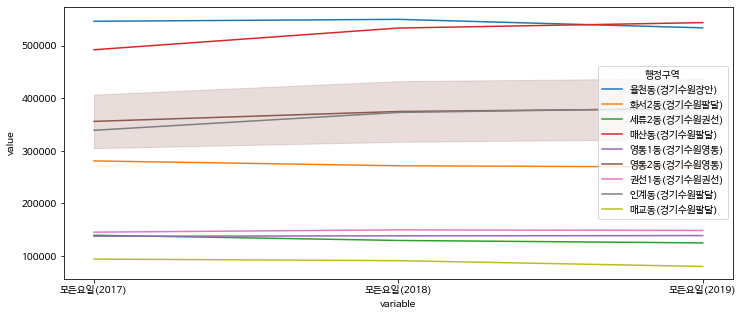

In [93]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=jan, x="variable", y="value", hue="행정구역")

<AxesSubplot:xlabel='variable', ylabel='value'>

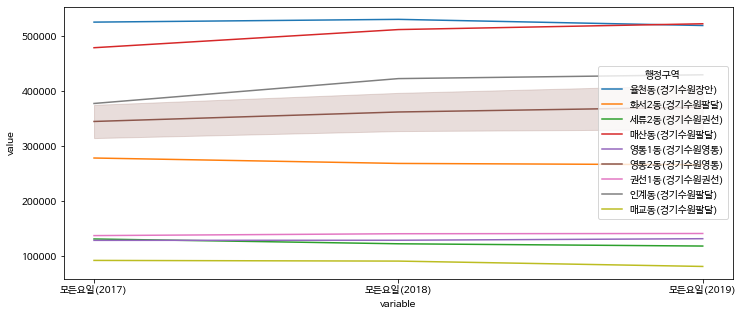

In [85]:
# 하차 
plt.figure(figsize=(12, 5))
sns.lineplot(data=jan, x="variable", y="value", hue="행정구역")

In [114]:
# , 로 split 해서 list 로 만들기 
bus["운행노선"] = bus["운행노선"].apply(lambda x : x.split(','))
bus["정류장유형"] = bus["정류장유형"].apply(lambda x : x.split(','))

In [118]:
bus["운행노선수"] = bus["운행노선"].apply(lambda x : len(x))

In [119]:
bus["운행노선수"].describe()

count   329756.000000
mean         8.188752
std          7.345783
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max         40.000000
Name: 운행노선수, dtype: float64

In [121]:
# 운행 노선 가장 많이 다니는 버스 정류소ID = 202000208
bus[bus["운행노선수"] == 40].head(1)

,일자,정류소ID,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,운행노선수
1580,2020-01-02,202000208,5809,2157,3652,13971,13971,0,수원역.노보텔수원,"시내,마을,공항",일반,경기도 수원시 매산동,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,126.999608,37.268112,"[10(경남여객), 10-2(경남여객), 10-5(경남여객), 1004(제부여객),...",노변정류장,40
